# Norwegian Postcodes: Plotting and checking

We did some plotting in the last notebook on this, but I figure that we can do a fair bit more. It might be nice to take a map, and underlay it to see the larger region. However, having tried this before, you can see that it doesn't provide much information. The colour of the polygons will obscure the dataunderneath. Similarly, the data underneath also obscures the range of colours in the polygons. Thus the wireframe data could be good to use, but sadly, the resolution from things like cartopy coastlines is too poor to use properly.

Thus given the poor performance of the image underlay and the wireframe, we would like to use this notebook to look at a cholorpeth map, but with just the postcodes and value data, and also with some basic features like coastlines, municipalities etc overlayed to give context.

## Getting in the libraries and data

In [1]:
import pandas as pd
import numpy as np
import pyproj
import geojson

from shapely import geometry
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon

import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches
import matplotlib.collections

# make sure that we are plotting inline
%matplotlib inline

In [2]:
df_raw = pd.read_pickle('postnummerlatlong.pkl')
df_raw.head()

,postnummer,poststed,kommune,coordinates,latlong
0,1339,VØYENENGA,219,"[[[245469.990020313, 6650942.7998409], [245370...","[[10.445696317019141, 59.91713244479797], [10...."
1,1361,ØSTERÅS,219,"[[[253912.000015147, 6653573.99987799], [25395...","[[10.593090602999617, 59.945811697526544], [10..."
2,1354,BÆRUMS VERK,219,"[[[248576.47001836, 6654230.96985486], [248488...","[[10.497083866689294, 59.948471950108775], [10..."
3,1346,GJETTUM,219,"[[[249541.000017632, 6651700.99986], [249317.0...","[[10.517359940671644, 59.92641147537095], [10...."
4,1362,HOSLE,219,"[[[253912.000015147, 6653573.99987799], [25385...","[[10.593090602999617, 59.945811697526544], [10..."


## Checking points

As I previously said, my old flat in Porsgrunn had the post code 3915, and the approximate location was latitude 59.142115, and longitude 9.655644. Lets see if this figures with the dataset we have. Going easy first, we actually see if it figures by selecting the polygon based on the postcode.

In [3]:
# point created by the location of the old flat (long, lat)
old_flat_latlong = np.array([9.655644, 59.142115])
old_flat = Point(old_flat_latlong)

# create the polygon from the Porsgrunn postcode
porsgrun_poly = Polygon(df_raw.latlong[df_raw.postnummer == 3915].values[0])

# check if polygon contains point
print("Polygon contains point: {}".format(porsgrun_poly.contains(old_flat)))

# check if a point is in the polygon 
print("Point is in polygon: {}".format(old_flat.within(porsgrun_poly)))

Polygon contains point: True
Point is in polygon: True


So the point is in the polygon. Thats a good sign. Lets look at how the postal district looks, along with the location of my old flat.

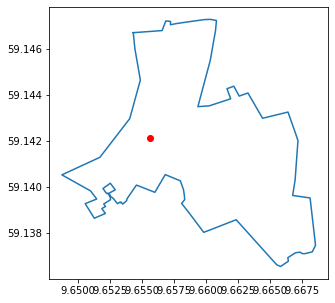

In [4]:
# set the figure up
plt.figure(figsize=(5, 5))

# plot the point
plt.plot(old_flat_latlong[0], old_flat_latlong[1], 'ro')

# set the polygon for porsgunn
porsgrun_polygon = geometry.Polygon(df_raw.latlong[df_raw.postnummer == 3915].values[0])
x,y = porsgrun_polygon.exterior.xy

# plot the polygon
plt.plot(x,y)
plt.show()

## Plotting

We are also interested in visualising data using the boundaries, by placing the polygons on top of maps. For this we could use the imagery sub library in cartopy. Additionally given data by postcode we might want to visualize the data by color schema.


### Colours by values in postcode

Lets take the region of Oslo, and visualise some data. We want to look at the number of street adresses per postcode. Bring offers this info [here](https://www.bring.no/english/advising/sending-something-with-bring/address-verification-services/postcodes/_/attachment/download/a6ed8cb3-f222-4ccb-b96a-dff3387c32d8:0ba35a54c4eda27d1cc209d2535825ad783a86c6/postcodes-and-number-of-street-road-addresses.xlsx)

In [5]:
df_bring = pd.read_excel('postcodes-and-number-of-street-road-addresses.xlsx', sheet_name='Number+proportion road addr')
df_bring.head()

,Postnummer,Poststed,Primærkommune,Kategori,Ant jun-14,And jun-14,Ant jul-14,And jul-14,Utvikling,Ant sep-14,...,Utvikling.20,Ant mai-16,And mai-16,Utvikling.21,Ant jun-16,And jun-16,Utvikling.22,Ant jul-16,And jul-16,Utvikling.23
0,1,OSLO,301 OSLO,P,pb,pb,pb,pb,pb,pb,...,pb,pb,pb,pb,pb,pb,pb,pb,pb,pb
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We are only interseted in the following columns: Postnummer, Poststed, Kategori, and Ant jun-16. We want to drop all rows that contain pd (a post box), and NaN.


In [6]:
cols = ['Postnummer', 'Poststed', 'Kategori', 'Ant jun-16']
df_bring.drop(df_bring.columns.difference(cols), 1, inplace=True)
df_bring.dropna(axis=0, inplace=True)
postboxes = df_bring[df_bring['Ant jun-16'] == 'pb'].index
df_bring.drop(postboxes, inplace=True)
df_bring.head()

,Postnummer,Poststed,Kategori,Ant jun-16
9,10,OSLO,B,1
14,15,OSLO,B,1
25,26,OSLO,G,1
36,37,OSLO,F,1
49,50,OSLO,G,6


Lets rename the coluns "Ant jun-16" to something like Number. And then merge in the latlong coordinates to get a dataframe with the number of street adresses per postcode. We drop all the columns we don't need.

In [7]:
df_bring.rename(columns={ "Ant jun-16" : "Number"}, inplace=True)
df_bring.head()

,Postnummer,Poststed,Kategori,Number
9,10,OSLO,B,1
14,15,OSLO,B,1
25,26,OSLO,G,1
36,37,OSLO,F,1
49,50,OSLO,G,6


In [8]:
df_number = df_bring.merge(df_raw, how='inner', left_on='Postnummer', right_on='postnummer', copy=True)
df_number.head()

,Postnummer,Poststed,Kategori,Number,postnummer,poststed,kommune,coordinates,latlong
0,10,OSLO,B,1,10,OSLO,301,"[[[261037.990011562, 6650006.61990434], [26097...","[[10.724401157105536, 59.91806265677275], [10...."
1,15,OSLO,B,1,15,OSLO,301,"[[[261566.730011304, 6648843.09990625], [26156...","[[10.735169955268098, 59.907949870588546], [10..."
2,26,OSLO,G,1,26,OSLO,301,"[[[261772.160011234, 6649414.36990679], [26176...","[[10.738175877481346, 59.91318397556555], [10...."
3,37,OSLO,F,1,37,OSLO,301,"[[[261534.790011333, 6649401.12990604], [26153...","[[10.73395834904496, 59.912928295154074], [10...."
4,50,OSLO,G,6,50,OSLO,301,"[[[262488.320010935, 6649327.77990904], [26249...","[[10.751045907608274, 59.91282147502632], [10...."


In [9]:
df_number.drop(columns=['Kategori', 'postnummer', 'poststed', 'coordinates'], inplace=True)
df_number.head()

,Postnummer,Poststed,Number,kommune,latlong
0,10,OSLO,1,301,"[[10.724401157105536, 59.91806265677275], [10...."
1,15,OSLO,1,301,"[[10.735169955268098, 59.907949870588546], [10..."
2,26,OSLO,1,301,"[[10.738175877481346, 59.91318397556555], [10...."
3,37,OSLO,1,301,"[[10.73395834904496, 59.912928295154074], [10...."
4,50,OSLO,6,301,"[[10.751045907608274, 59.91282147502632], [10...."


Lets get some salient information out of this. We want to see the distribution.

Range of Number of houses in Oslo is from 1 to 1061


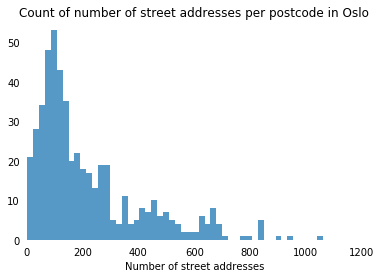

In [10]:
oslo_post_poly = df_number.latlong[df_number['Poststed']== 'OSLO'].values
oslo_post_number = df_number.Number[df_number['Poststed']== 'OSLO'].values

min_number = oslo_post_number.min()
max_number = oslo_post_number.max()

print("Range of Number of houses in Oslo is from {} to {}".format(min_number, max_number))

# the histogram of the data
n, bins, patches = plt.hist(oslo_post_number, 50, alpha=0.75)

plt.xlabel('Number of street addresses')
#plt.ylabel('Count')
plt.title('Count of number of street addresses per postcode in Oslo')
plt.xlim(0, 1200)
plt.ylim(0, 55)
plt.box(on=None)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=True)
plt.show()

Okay, so a linear colour bar could work. 

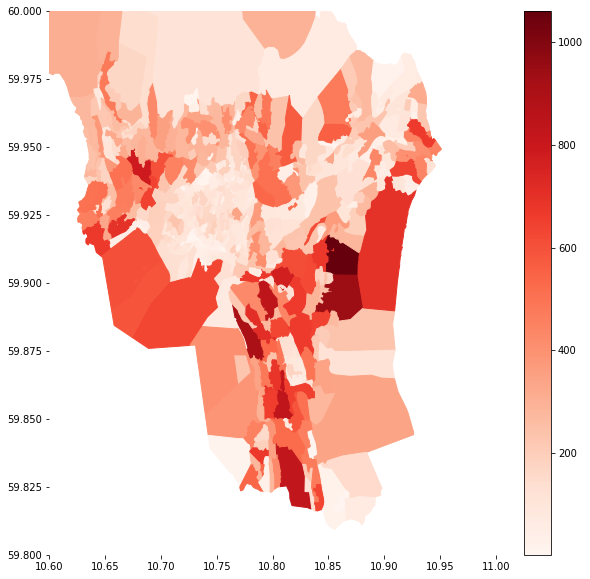

In [11]:
fig, ax = plt.subplots(figsize=(10,10))

# set the colour map colors
cmap=plt.cm.Reds

# get the maximum and minimum values
min_number = oslo_post_number.min()
max_number = oslo_post_number.max()
norm=plt.Normalize(min_number, max_number)

for i in list(range(len(oslo_post_poly))):
    # set the polygon dimensions
    polygon = geometry.Polygon(oslo_post_poly[i])
    x,y = polygon.exterior.xy
    
    # set the colour of the polygon
    c = cmap((oslo_post_number[i] - min_number)/(max_number - min_number))
    
    # plot the polygons
    p = plt.fill(x, y, color=c)
    
# seting up the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(oslo_post_number)
fig.colorbar(sm, ax=ax)

# set the limits of the image
ax.set_xlim([10.6, 11])
ax.set_ylim([59.8, 60])
plt.box(on=None)

plt.show()

Thats really nice to see, but I think that it would look better with some map features on it - give the data some context. How about coastlines or something like Fylker (Counties) or Kommuner (Municipalities).


## On top of a map

Given the issues that we have had with the underlay image from Open Street Map - which is good for single points, rather than cloropeth style data overlay, and also the poor resolution of Cartoply coastlines - which is better for data over greater distances, we needed to find something else. Good old Norwegian open data comes to the rescue, again. The dataset ["Norwegian Counties and Municipalities (clipped by coastline) 2019"](https://kartkatalog.geonorge.no/metadata/geonorge/norske-fylker-og-kommuner-illustrasjonsdata-2019-klippet-etter-kyst/cb02ab77-d3e6-4500-8a92-ea67367e7734) by GeoNorge, has this information. Thus we can start to look at this data.'

1. Fylker19.geojson
2. Kommuner19.geojson

Lets load the geojson library and then load up the kommuner file.

In [12]:
with open('Kommuner19.geojson') as f:
    gj = geojson.load(f)

In [13]:
gj.keys()

dict_keys(['type', 'name', 'crs', 'features'])

In [14]:
gj['features'][0].keys()

dict_keys(['type', 'geometry', 'properties'])

In [15]:
gj['features'][0]['properties']

{'kommunenummer': 2003, 'kommunenavn': 'VadsÃ¸'}

In [16]:
gj['features'][0]['geometry']['type']

'MultiPolygon'

Okay, so the interesting stuff is in the 'features' key. The 'geometry' key contains both the 'coordinates' for each feature, but also the type that is stored. Here the type of data structure is 'MultiPolygon'. This is more difficult to extract than before, where we simply had the polygons. Also we need to know the reference dataum for the map, as the coordiantes given are also in Easting and Northing as before. That will need to be converted. 

Also within 'features', in the 'properties' key we have a list of all the kommune. Lets see the number of Kommuner that are out there.

In [17]:
print('Number of Kommune is {}.'.format(len(gj['features'])))

Number of Kommune is 422.


As a test, lets just look at the coordinates for the Kommune Oslo. You can see from wikipedia the [ISO codes](https://en.wikipedia.org/wiki/List_of_municipalities_of_Norway) for the Kommune. Unlike before for the postcodes, where we just had polygons, here the multipolygons means we just need to cycle through each polygon in the list. We also need to convert this to a latitude and longitude.

In [18]:
for kommune in list(range(len(gj['features']))):
    if gj['features'][kommune]['properties']['kommunenummer'] == 301:
        oslo_kommune_poly = gj['features'][kommune]['geometry']['coordinates']

In [19]:
def project_array(poly_cords):
    # get the poly array in the dataframe into a np array
    poly_array = np.array(poly_cords[0])
    
    # set the current projection datum
    NN54 = pyproj.Proj(init='epsg:6173')
    
    # set the new projection datum
    wgs84 = pyproj.Proj(init='epsg:4326')
    
    # extract the 
    fx, fy = pyproj.transform(NN54, wgs84, poly_array[:, 0], poly_array[:, 1])
    
    # combine the x and y
    coords = np.dstack([fx, fy])[0] 
    
    return coords

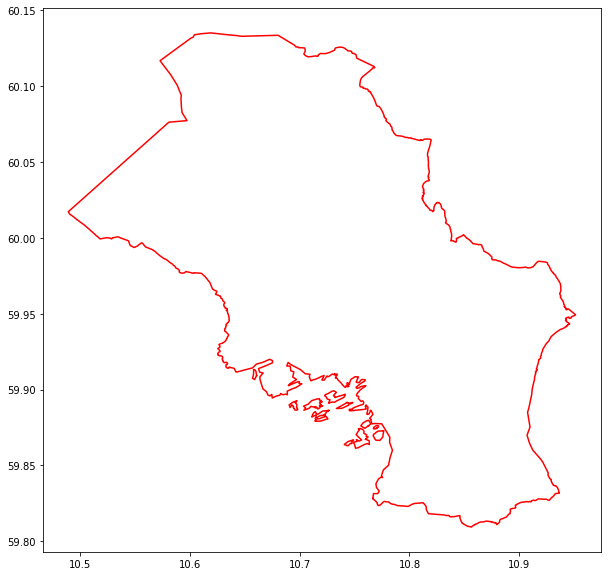

In [20]:
fig, ax = plt.subplots(figsize=(10,10))

for c in oslo_kommune_poly:
    # set the polygon for porsgunn
    polygon = geometry.Polygon(project_array(c))
    x,y = polygon.exterior.xy

    # plot the polygon
    plt.plot(x,y, 'r')
plt.show()

Now lets plot that with the postcode data. That will be a nice addition to the image.

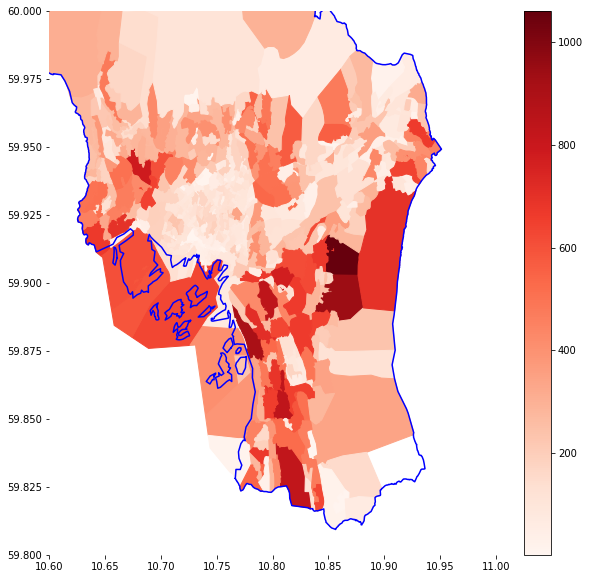

In [21]:
fig, ax = plt.subplots(figsize=(10,10))

# set the colour map colors
cmap=plt.cm.Reds

# get the maximum and minimum values
min_number = oslo_post_number.min()
max_number = oslo_post_number.max()
norm=plt.Normalize(min_number, max_number)

for i in list(range(len(oslo_post_poly))):
    # set the polygon dimensions
    polygon = geometry.Polygon(oslo_post_poly[i])
    x,y = polygon.exterior.xy
    
    # set the colour of the polygon
    c = cmap((oslo_post_number[i] - min_number)/(max_number - min_number))
    
    # plot the polygons
    p = plt.fill(x, y, color=c)
    
# seting up the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(oslo_post_number)
fig.colorbar(sm, ax=ax)

# set the limits of the image
ax.set_xlim([10.6, 11])
ax.set_ylim([59.8, 60])
plt.box(on=None)

for c in oslo_kommune_poly:
    # set the polygon for porsgunn
    polygon = geometry.Polygon(project_array(c))
    x,y = polygon.exterior.xy

    # plot the polygon
    plt.plot(x,y, 'b')

plt.show()

Thats really good, much better than the cartopy options. I think I will be using that a fair bit to visualize data from Oslo.